# Microgrid sizing optimization: comparing Blackbox vs Algebraic approaches

This notebook is a continuation of [Microgrid_optimization_JuMP.ipynb](Microgrid_optimization_JuMP.ipynb), where the algebraic approach is reimplemented in reusable functions.

Then, the result of is compared to the blackbox optimization with rule-based energy management of Microgrids.jl, in the spirit of (El Sayegh, 2022).  It corresponds to the developments from [Microgrid_sizing_optimization_relax.ipynb](Microgrid_sizing_optimization_relax.ipynb) consolidated here.

Results were presented first at the OpEnMod Grenoble workshop 2023 and then at ENS Rennes in May 2024, but are not yet published.

Latest update: 
- July 2024:
    - use the Smoothing structure of Microgrids 0.11 and expose the relaxation gain in both Blackbox and Algebraic approaches
    - switch to anonymous variables and `add_var!` function to pave the way to two-stage SP
    - first two-stage SP draft
    - then switched back from using `add_var!`, still to be done for 2SP

In [1]:
using Microgrids

# Optimization
using JuMP
using HiGHS # Linear Programming solver
using Clp
using NLopt # Blackbox nonlinear solvers

# Display
using Printf # pretty print results
using PyPlot

Check version of Microgrids.jl (v0.11.0 needed)

In [2]:
import Pkg
Pkg.status("Microgrids")

Status `~/.julia/environments/v1.10/Project.toml`
  [bd581358] Microgrids v0.11.0


## Problem setup

In [3]:
include("./example/Microgrid_Wind-Solar_data.jl");

Base Wind-Solar Microgrid project definition functions...


In [4]:
const tseries = load_microgrid_tseries();

loading times series from data/Ouessant_data_2016.csv...


In [5]:
"""Create a Microgrid project description of size `x`

x should be [
    power_rated_gen,
    energy_rated_sto,
    power_rated_pv,
    power_rated_wind
] (in kW or kWh)

Apart from the sizing, the project is based on parameters
defined by the function `create_mg_base` which
defaults to the globally defined `create_mg_base`.
This allows modifying some project parameters.
"""
function create_microgrid(x; create_mg_base=create_mg_base)
    mg = create_mg_base()

    # force ConsistentSalvage, necessary for comparison with LP approaches
    mg.project.salvage_type = ConsistentSalvage

    # Set the size
    mg.generator.power_rated = x[1] # power_rated_gen
    mg.storage.energy_rated = x[2] # energy_rated_sto
    mg.nondispatchables[1].power_rated = x[3] # power_rated_pv
    mg.nondispatchables[2].power_rated = x[4] # power_rated_wind

    return mg
end

x_base = [1000. 1000. 1000. 1000.]
mg_base = create_microgrid(x_base)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(1000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1000.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399,

In [6]:
"""capital recovery factor for discount rate `i` and duration `T`
CRF is such that Cann = NPC*CRF
"""
function CRF(i,T)
    if i != 0.0
        a = (1+i)^T
        return i*a/(a-1)
    else
        return 1/T
    end
end
CRF(0.05, 25)

0.0709524572992296

### Sizing bounds for each component

In [7]:
Pload_max = maximum(tseries.Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

xmax = [
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max
    ]

Max load power: 1707.0 kW

4-element Vector{Float64}:
  2048.4
 17070.0
 17070.0
  8535.0

## Blackbox microgrid sizing setup

### Objective function

- first bi-objective function x ↦ (lcoe, shedding rate)(x)
- then wrapped into a mono objective x ↦ J(x) by using a penalty for the excess of shedding rate
  - and match the interface expected by NLopt's optimizers

In [8]:
"""Multi-objective criterion for microgrid performance: lcoe, shedding rate.

Discontinuous computations can optionally be smoothed (relaxed) using the
`Smoothing` parameters `transition` and `gain` (like in `simulate`).

Optionally, the base Microgrid can be changed with `create_mg_base`.
"""
function obj_multi(x; smoothing::Smoothing, create_mg_base=create_mg_base)
    mg = create_microgrid(x; create_mg_base)
    # Launch simulation:
    traj, stats, costs = simulate(mg, smoothing)
    # Extract KPIs of interest
    lcoe = costs.lcoe # $/kWh
    shed_rate = stats.shed_rate; # in [0,1]
    return lcoe, shed_rate
end

obj_multi

In [9]:
obj_multi(x_base; smoothing=NoSmoothing),
obj_multi(x_base; smoothing=Smoothing(1.0))

((0.20781653603718364, 0.00650933126708814), (0.1857600639716875, 0.00650933126708814))

### Wrapper of the blackbox optimization process

In [10]:
"""Optimize sizing of microgrid based on the global `obj_multi` function
which is reformulated as a single objective function

Parameters:
- `x0`: initial sizing (for the algorithms which need them)
- `shed_max`: load shedding penalty threshold should be in  [0,1[

Keyword parameters:
- `smoothing`: amount of smoothing of discontinuous computations
- `create_mg_base`: creates the base Microgrid project (default `create_mg_base`)

Blackbox optimization parameters (all optional):
- `algo` could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
- `maxeval`: maximum allowed number of calls to the objective function,
  that is to the microgrid simulation
- `xtol_rel`: termination condition based on relative change of sizing, see NLopt doc.
- `srand`: random number generation seed (for algorithms which use some stochastic search)

Sizing maximum bounds are taken as the global variables `xmax`.
"""
function optim_mg_bb(x0; shed_max, 
        smoothing::Smoothing, create_mg_base=create_mg_base,
        algo=:GN_CRS2_LM, max_eval=10_000, xtol_rel=1e-5, srand=1
    )

    """Mono-objective criterion: LCOE + penalty if shedding rate > `shed_max`
    with signature adapted to NLopt with `grad` as 2nd argument
    """
    function obj(x, grad, shed_max, w_shed_max=1e5)
        lcoe, shed_rate = obj_multi(x; smoothing, create_mg_base)
        over_shed = shed_rate - shed_max
        penalty = over_shed > 0.0 ? w_shed_max*over_shed : 0.0
        J = lcoe + penalty
    end
    
    nx = length(x0) # number of optim variables
    opt = Opt(algo, nx)
    NLopt.srand(srand)
    
    opt.lower_bounds = [0., 0., 1e-3, 0.] # 1e-3 instead of 0.0, because LCOE is NaN if ther is exactly zero generation
    opt.upper_bounds = xmax/1000
    opt.min_objective = (x_norm, grad) -> obj(x_norm*1000, grad, shed_max)
    opt.xtol_rel = xtol_rel
    opt.maxeval = max_eval
    
    (fopt, x_norm_opt, ret) = optimize(opt, x0/1000)
    return x_norm_opt*1000, ret, opt.numevals
end

optim_mg_bb

Starting point of blackbox optim: also derived from maximal load power

In [11]:
x0 = [1.0, 3.0, 3.0, 2.0] * Pload_max

4-element Vector{Float64}:
 1707.0
 5121.0
 5121.0
 3414.0

Test run of BB optim.

Case with 0.25 battery price (Grenoble workshop slides)

In [12]:
algo = :GN_CRS2_LM # could be one of GN_CRS2_LM, GN_DIRECT, GN_ESCH, LN_SBPLX...
shed_max = 0.00 # in [0,1]
max_eval=10_000
srand=1
#smoothing=NoSmoothing
smoothing=Smoothing(1.0) # full relaxation, default value of `gain` = 1.0
#smoothing=Smoothing(1.0, 2) # full relaxation, but attempting to compensate with `gain`

"""Modify Microgrid project by *multiplying* base price values:
- `sto`: `mg.storage.investment_price` 
- `gen`: `mg.generator.investment_price` 
- `fuel`: `mg.generator.fuel_price`
"""
function modify_mg_prices(;sto=1.0, gen=1.0, fuel=1.0)
    println("mg prices modifications: sto*=$sto, gen*=$gen, fuel*=$fuel")
    function modify_mg(mg)
        mg.storage.investment_price *= sto
        mg.generator.investment_price *= gen
        mg.generator.fuel_price *= fuel
        return mg # return mg to allow chaining
    end
    return modify_mg
end

create_mg_modified = modify_mg_prices(sto=0.25) ∘ create_mg_base

@time xbb, ret, numevals = optim_mg_bb(x0; shed_max, smoothing,
                                      create_mg_base = create_mg_modified,
                                      algo, max_eval, srand)

@printf("%s algo: %s after %d iterations (with %s). \nx*=", algo, ret, numevals, smoothing)
println(round.(xbb; digits=1)) # kW or kWh
lcoe_bb, shed_rate_bb = obj_multi(xbb; smoothing, create_mg_base = create_mg_modified)
println("LCOE*: ", lcoe_bb)
println("shed*: ", shed_rate_bb)

mg prices modifications: sto*=0.25, gen*=1.0, fuel*=1.0
  0.985440 seconds (862.48 k allocations: 2.039 GiB, 4.91% gc time, 27.41% compilation time)
GN_CRS2_LM algo: XTOL_REACHED after 2549 iterations (with Smoothing(1.0, 1.0)). 
x*=[1577.2, 4766.5, 1969.6, 1249.7]
LCOE*: 0.17232666449068842
shed*: 0.0


In [13]:
round.(xbb; digits=1)

4-element Vector{Float64}:
 1577.2
 4766.5
 1969.6
 1249.7

Detailed performance statistics of blackbox optim:

In [14]:
mgopt_bb = create_microgrid(xbb; create_mg_base = create_mg_modified);
mgopt_bb.generator.power_rated

1577.1812661847691

In [15]:
traj_bb, stats_bb, costs_bb = simulate(mgopt_bb, smoothing)
traj_bb, stats_bb_norelax, costs_bb_norelax = simulate(mgopt_bb)
costs_bb.lcoe, stats_bb.renew_rate

(0.17232666449068842, 0.7845367569966673)

## All-in-one algebraic approach with JuMP

### basic time series reduction

In [16]:
"""reduce the year time series `x` to `ndays` ≤ 365
sr=24: data sampling rate / day. 24 means hourly time step.

The method is *basic*:
it samples `ndays` days evenly spaced by (365 ÷ `ndays`) days

with ndays=365, returns the orinal series
"""
function ts_reduction(x, ndays, sr=24)
    out = zeros(ndays*sr)
    @assert ndays<=365
    Δdays = 365 ÷ ndays
    for i in 1:ndays
        offset_in = (i-1)*Δdays*sr
        offset_out = (i-1)*sr
        out[offset_out+1:offset_out+sr] = x[offset_in+1:offset_in+sr]
    end
    return out
end

ts_reduction

Generator of piecewise linear approximation to the “annualized size” function of size $x$ and usage $u$:

$$x_{ann}(x,u) = x.CRF(T(x, u))$$

with lifetime varying with size and usage as $T=x/u$.

In [17]:
"""intercept and slope of tangent to function g:z → 1/(1-e^(-1/z))  at point `z0`

Usage: with gi, g1 = g_asym(z0),
then g(z) ~ gi + g1*z around z0
gi: intercept at z=0
g1: slope
"""
function g_tan(z0)
    z=z0
    emiz = exp(-1/z)
    g = 1/(1-emiz) # g(z)
    g1 = emiz/(z^2*(1-emiz)^2) # g'(z)
    ginter = g - g1*z
    return ginter, g1
end
g_tan(1e-3), g_tan(1/2), g_tan(1e3)

((1.0, 0.0), (0.7944868122665105, 0.7240616609663105), (0.500166666631003, 0.9999999166667313))

In [18]:
"""Piecewise linear approximation of “annualized size” function of size and usage

Parameters:
- Xann, X, U: JuMP variables or expressions
- discount_rate: Real number in [0,1] (negative discount not implemented)
- z_tan: list of z0 values where to use tangents of g(z).

Recommended values:
- z_tan = [0.5]: 5% CRF underestimation error
- z_tan = [0.28, 0.5, 1.0]: 1.6% error
- z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]: 0.23% error

Tangents at z=0 and z->+infty are also added, so no need to add these.

Returns the vector of constraints
"""
function cons_Xann_usage!(model, Xann, X, U, discount_rate, z_tan=[0.28, 0.5, 1.0])
    r = discount_rate/log(1+discount_rate)
    # stacked tangents: (ginter, g1) for each z0 in z_tan, including z=0 and +infty
    tan_params = [
        (1.0, 0.) # z0 = 0, yields Xann >= X*discount_rate
        [(g_tan(z0)[1], g_tan(z0)[2]) for z0 in z_tan]
        (0.5, 1.0) # z0 -> +inftyn yields Xann >= X*discount_rate*0.5 + U*r
    ]
    ntan = length(tan_params)
    cvec = @constraint(model, [k=1:ntan],
        Xann >= X*discount_rate*tan_params[k][1]
              + U*r*tan_params[k][2]
    )
    cname = "c_" * name(Xann) *"_"* name(X) *"_"* name(U)
    set_name.(cvec, [cname * "[$k]" for k=1:ntan])
    return cvec
end

cons_Xann_usage!

Test:

In [19]:
mtest = Model()
@variable(mtest, Xann)
@variable(mtest, X)
@variable(mtest, U)
cons_Xann_usage!(mtest, Xann, X, U, 0.05)

5-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 c_Xann_X_U[1] : Xann - 0.05 X ≥ 0
 c_Xann_X_U[2] : Xann - 0.04613111050299047 X - 0.3890816707882075 U ≥ 0
 c_Xann_X_U[3] : Xann - 0.039724340613325526 X - 0.7420160121329831 U ≥ 0
 c_Xann_X_U[4] : Xann - 0.03306515563307671 X - 0.9435032755891112 U ≥ 0
 c_Xann_X_U[5] : Xann - 0.025 X - 1.0247967157143927 U ≥ 0

### Algebraic model definition

→ this should be split in a package?

#### Helpers

#### Core model definition

In [23]:
"""Build one stage of microgrid sizing optimization JuMP model

# Parameters:
- `mg`: base Microgrid description (with 1kW(h) ratings) for e.g. price parameters and load data
- `shed_max`: load shedding bound, as a fraction of cumulated desired load energy, in [0,1]
- `model_data`::Dict to store variable references and constraints. A JuMP model should be included in `data["model"]`

# Optional keyword parameters
- `ndays=365`: data reduction
- `fixed_lifetimes`: true or false (default)
- `gen_hours_assum`: assumed generator operation hours when fixed_lifetimes, in 0 – 8760 h/y (default 3000)
- `relax_gain`: 1.0 by default. Increase to try to compensation the underestimation
  of e.g. generator operating hours due to linearization.
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max
"""
function build_optim_mg_stage!(mg, model_data::Dict{String,Any};
        shed_max = 0.0,
        ndays = 365,
        fixed_lifetimes = false,
        gen_hours_assum = 3000.,
        relax_gain = 1.0,
    )
    println("Building stage problem with $ndays days...")
    dt = mg.project.timestep
    discount_rate = mg.project.discount_rate
    CRFproj(T) = CRF(mg.project.discount_rate, T) 

    K = ndays*24 # h
    ts_reduction_ndays(x) = ts_reduction(x, ndays)

    Pload = mg.load |> ts_reduction_ndays
    Eload_desired = sum(Pload)*dt*365/ndays
    model_data["Pload"] = Pload
    model_data["Eload_desired"] = Eload_desired

    # (works because the rated power in mg are set to 1 kW)
    cf_pv   = production(mg.nondispatchables[1]) |> ts_reduction_ndays
    cf_wind = production(mg.nondispatchables[2]) |> ts_reduction_ndays;

    ### JuMP model definition
    model = model_data["model"] # JuMP model
    md = model_data # short name

    ##  Sizing variables
    md["power_rated_gen"]  = @variable(model, 0 <= power_rated_gen  <= power_rated_gen_max)
    md["energy_rated_sto"] = @variable(model, 0 <= energy_rated_sto <= energy_rated_sto_max)
    md["power_rated_pv"]   = @variable(model, 0 <= power_rated_pv   <= power_rated_pv_max)
    md["power_rated_wind"] = @variable(model, 0 <= power_rated_wind <= power_rated_gen_max)

    ## Power flows for each component
    
    # Non dispatchable sources (renewables)
    md["pv_potential"] = @variable(model, pv_potential[1:K])
    @constraint(model, pv_potential .== power_rated_pv*cf_pv)
    md["wind_potential"] = @variable(model, wind_potential[1:K])
    @constraint(model, wind_potential .== power_rated_wind*cf_wind);
    md["renew_potential"] = renew_potential = pv_potential + wind_potential

    # Desired net load (before spillage of excess renewables and load shedding)
    md["Pnl"] = @variable(model, Pnl[1:K])
    @constraint(model, Pnl .== Pload .- renew_potential)

    # Renewables spillage and load shedding
    md["Pspill"] = @variable(model, Pspill[1:K] >= 0)
    md["Pshed"]  = @variable(model, Pshed[1:K] >= 0)
    
    # Dispatchable generator
    md["Pgen"] = @variable(model, Pgen[1:K] >= 0)
    @constraint(model, Pgen .<= power_rated_gen)

    ## Energy storage
    # Charge and discharge power (net of losses)
    md["Psto_cha"] = @variable(model, Psto_cha[1:K] >= 0)
    md["Psto_dis"] = @variable(model, Psto_dis[1:K] >= 0)
    # Energy level and its bounds
    md["Esto"] = @variable(model, Esto[1:K+1])
    @constraint(model, Esto .<= energy_rated_sto) # SoCmax = 1 implicitly
    @constraint(model, Esto .>= mg.storage.SoC_min*energy_rated_sto) # often 0
    # Power constraints
    @constraint(model, Psto_cha .<= mg.storage.charge_rate    * energy_rated_sto) #
    @constraint(model, Psto_dis .<= mg.storage.discharge_rate * energy_rated_sto) # double the solving time with HiGHS and MOI 1.30.0, when there is the Pgen penalty!!
    # variant that embeds the two preceding ones, using that fact that Psto_cha(k) * Psto_dis(k) = 0
    @constraint(model, Psto_cha/mg.storage.charge_rate + Psto_dis/mg.storage.discharge_rate  .<=  energy_rated_sto)
    # Evolution of the State of Energy,
    # with piecewise linear in P loss term (aka constant efficiency model)
    a = mg.storage.loss_factor
    md["stodyn"] = @constraint(model, [k=1:K],
        Esto[k+1] == Esto[k] + (Psto_cha[k] - Psto_dis[k] - a*(Psto_cha[k]+Psto_dis[k]))*dt,
        base_name = "stodyn"
    )
    # Storage cyclicity
    @constraint(model, Esto[K+1] == Esto[1])
    # not implemented: force initial SoC # TODO: activate to make it comparable with BB
    #@constraint(model, Esto[1] == mg.storage.SoC_ini * energy_rated_sto)
    
    ## Power balance
    md["balance"] = @constraint(model, balance,
        Pgen + (Psto_dis - Psto_cha) - Pspill .== Pnl - Pshed,
    )
    
    if shed_max == 0.0
        println("zero load shedding allowed")
        fix.(Pshed, 0.0; force=true);
    else
        println("load shedding allowed: $shed_max")
        Eshed = sum(Pshed)*dt * 365/ndays
        @constraint(model, Eshed <= Eload_desired*shed_max)
    end

    ### Costs
    z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0] # for Xann or CRF PWL approx
    #z_tan = [0.5] # simpler PWL, as used in Grenoble slides
    # Generator costs
    Egen = sum(Pgen)*dt * 365/ndays # Generator yearly energy

    if fixed_lifetimes
        print("Fixed generator lifetime hypothesis: ")
        gen_lifetime = mg.generator.lifetime_hours / gen_hours_assum # years
        println("$gen_lifetime y, assuming $gen_hours_assum  h/y of usage")
        Pgen_rated_ann = power_rated_gen * CRFproj(gen_lifetime)
    else
        println("Usage-dependent generator lifetime model (relax_gain=", relax_gain,")")
        md["Pgen_rated_ann"] = @variable(model, Pgen_rated_ann >= 0) # annualized size
        md["Ugen"] = @variable(model, Ugen >= 0) # cumulated usage
        @constraint(model, Ugen == Egen*relax_gain/mg.generator.lifetime_hours); # kW/y
        cpwl_gen = cons_Xann_usage!(model,
            Pgen_rated_ann, power_rated_gen, Ugen,
            discount_rate, z_tan)
    end   
    Cgen_om = fixed_lifetimes ? 
        mg.generator.om_price_hours * gen_hours * power_rated_gen :
        mg.generator.om_price_hours * relax_gain * Egen

    Cgen = mg.generator.investment_price * Pgen_rated_ann +
           Cgen_om +
           mg.generator.fuel_price * mg.generator.fuel_slope * Egen;# $/y
    
    # Battery costs
    md["Esto_rated_ann"] = @variable(model, Esto_rated_ann >= 0) # annualized size
    Csto = mg.storage.investment_price * Esto_rated_ann +
           mg.storage.om_price * energy_rated_sto
    # A) Effect of calendar lifetime:
    CRFsto_cal = CRFproj(mg.storage.lifetime_calendar)
    @constraint(model, Esto_rated_ann >= energy_rated_sto*CRFsto_cal)
    # B) Effect of cycling
    if ~fixed_lifetimes
        md["Usto"] = @variable(model, Usto >= 0) # cumulated usage
        E_through_sto = (sum(Psto_cha) + sum(Psto_dis))*dt * 365/ndays # cumulated throughput
        @constraint(model, Usto == E_through_sto/(2*mg.storage.lifetime_cycles))
        cpwl_sto = cons_Xann_usage!(model,
            Esto_rated_ann, energy_rated_sto, Usto,
            discount_rate, z_tan)
    end

    # Wind and solar costs
    pv = mg.nondispatchables[1]
    Cpv = pv.investment_price * power_rated_pv * CRFproj(pv.lifetime) + 
          pv.om_price * power_rated_pv
    wind = mg.nondispatchables[2]
    Cwind = wind.investment_price * power_rated_wind * CRFproj(wind.lifetime) + 
        wind.om_price * power_rated_wind

    # Total cost
    Cann = Cgen + Csto +  Cpv + Cwind

    # Small penalty to add to Cann to emulate a biobjective problem.
    # Warning, it can make the problem not well numerically conditioned in some *circumstances*
    # Only useful for plotting nice trajectories
    decrease = collect(1 .- (1:K)/K) # sequence from 0.99x to 0
    #penal = 1e-5*sum((Psto_cha-Psto_dis).*decrease)*dt
    penal = 1e-5*sum(Pgen.*decrease)*dt

    md["Cann"] = Cann
    md["LCOE"] = Cann/Eload_desired
    md["penal"] = penal

    # Unregister all variables
    for var in keys(object_dictionary(model))
        unregister(model, var)
    end

    return nothing
end

build_optim_mg_stage!

In [24]:
"""Setup microgrid sizing optimization model using JuMP

# Parameters:
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- `optimizer`: JuMP compatible optimization solver

# Optional keyword parameters
- `ndays=365`: data reduction
- `fixed_lifetimes`: true or false (default)
- `gen_hours_assum`: assumed generator operation hours when fixed_lifetimes, in 0 – 8760 h/y (default 3000)
- `relax_gain`: 1.0 by default. Increase to try to compensation the underestimation
  of e.g. generator operating hours due to linearization.
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max

Returns:
- mg: base microgrid
- model_data Dict, with variables, named constraints and the JuMP model
- LCOE expression
"""
function setup_optim_mg_jump(optimizer;
        shed_max=0.0,
        ndays=365,
        fixed_lifetimes=false,
        gen_hours_assum = 3000.,
        relax_gain = 1.0,
        create_mg_base=create_mg_base)
    
    # base Microgrid with 1kW(h) ratings
    mg = create_microgrid([1., 1., 1., 1.]; create_mg_base)
    
    model_data = Dict{String,Any}()

    # JuMP model setup
    model = Model(optimizer)
    set_silent(model)
    model_data["model"] = model

    build_optim_mg_stage!(mg, model_data;
                          shed_max, ndays, fixed_lifetimes, gen_hours_assum, relax_gain)

    # Set optimization objective
    @objective(model, Min, model_data["Cann"])#+model_data["penal"])

    return mg, model_data, model_data["LCOE"]
end

setup_optim_mg_jump

Test setup function to get JuMP model.

In [25]:
optimizer = HiGHS.Optimizer

mg_base, model_data, LCOE_expr = setup_optim_mg_jump(optimizer; shed_max)

model_data["model"]

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)


A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 78849
├ num_constraints: 140198
│ ├ AffExpr in MOI.EqualTo{Float64}: 43803
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8782
│ ├ AffExpr in MOI.LessThan{Float64}: 43801
│ ├ VariableRef in MOI.EqualTo{Float64}: 8760
│ ├ VariableRef in MOI.GreaterThan{Float64}: 35048
│ └ VariableRef in MOI.LessThan{Float64}: 4
└ Names registered in the model: none

Remarks on model size:

- stage problem has 78 849 variables (9*8760 + 9)
- without storage charge and discharge rate constraints: -3*8760 (17 521 instead of 43 801) constraints `AffExpr`-in-`MathOptInterface.LessThan{Float64}`
  
```
A JuMP Model
Minimization problem with:
Variables: 78849
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 43803 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 8786 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 17521 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 8760 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 35048 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
```

Wrapper of algebraic optimization (includes diagnostics)

In [26]:
"""Optimize sizing of microgrid optimization using JuMP

Parameters: see `setup_optim_mg_jump`. Extra optional parameter:
- `model_custom`: a function taking `model_data` as arg and which can modify the optimization model
"""
function optim_mg_jump(optimizer;
        shed_max=0.0,
        ndays=365,
        fixed_lifetimes=false,
        gen_hours_assum = 3000.,
        relax_gain = 1.0,
        create_mg_base=create_mg_base,
        model_custom=nothing
    )

    # Create model
    mg_base, model_data, LCOE = setup_optim_mg_jump(optimizer;
        shed_max, ndays, fixed_lifetimes, gen_hours_assum, relax_gain,
        create_mg_base
    )
    md = model_data
    model = md["model"]

    if model_custom !== nothing
        model_custom(model_data)
    end
    
    # Optimize
    @time JuMP.optimize!(model)

    # Extract results
    LCOE_opt = value(LCOE)
    xopt = value.([
        md["power_rated_gen"]
        md["energy_rated_sto"]
        md["power_rated_pv"]
        md["power_rated_wind"]
    ])
    
    Tgen = value(md["power_rated_gen"]/md["Ugen"])
    CRFgen_relax = value(md["Pgen_rated_ann"]/md["power_rated_gen"])
    Tcyc = value(md["energy_rated_sto"]/md["Usto"])
    Tsto = min(Tcyc, mg_base.storage.lifetime_calendar)
    CRFsto_relax = value(md["Esto_rated_ann"]/md["energy_rated_sto"])

    # Diagnostics about annualized sized relaxation
    # i.e. PWL approx of CRF
    CRFproj(T) = CRF(mg_base.project.discount_rate, T)

    diagnostics = (
        # Generator
        Ugen = value(md["Ugen"]),
        Tgen = Tgen,
        CRFgen = CRFproj(Tgen),
        CRFgen_relax = CRFgen_relax,
        CRFgen_relax_rel = CRFgen_relax/CRFproj(Tgen),
        # Storage
        Usto = value(md["Usto"]),
        Tcyc = Tcyc,
        Tsto = Tsto,
        CRFsto = CRFproj(Tsto),
        CRFsto_relax = CRFsto_relax,
        CRFsto_relax_rel = CRFsto_relax/CRFproj(Tsto)
    )

    traj = (
        Pgen = value.(md["Pgen"]),
        Psto = value.(md["Psto_dis"] - md["Psto_cha"]),
        Esto = value.(md["Esto"]),
        Pshed = value.(md["Pshed"])
    )
    return xopt, LCOE_opt, diagnostics, traj, md
    
end

optim_mg_jump

### Test Algebraic optim
- Case with 0.25 battery price (Grenoble workshop slides)

HiGHS solver choice: https://ergo-code.github.io/HiGHS/stable/options/definitions/#solver

In [28]:
optimizer = optimizer_with_attributes(HiGHS.Optimizer,
    "solver" => "choose" # alternative to "choose" (default): ipm: best, simplex: quite close and pdlp: terrible (1700s)
)
#optimizer = Clp.Optimizer
xalg, lcoe_alg, diagnostics, traj_alg, model_data = optim_mg_jump(optimizer;
    shed_max,
    #ndays=10,
    relax_gain = smoothing.gain,
    create_mg_base = create_mg_modified,
)
lcoe_alg

Building stage problem with 365 days...
zero load shedding allowed
Usage-dependent generator lifetime model (relax_gain=1.0)
  8.918156 seconds (1.22 M allocations: 120.601 MiB, 0.57% gc time)


0.17159371860032874

In [29]:
round.(xalg; digits=1) # optimal sizing

4-element Vector{Float64}:
 1151.3
 5227.9
 2055.0
 1234.5

Expected LCOE: `0.171 593 718 600 3287` (without any "small" penalty, with ×0.25 storage cost).

Expected sizing $x^*$:
```
 1151.3
 5227.9
 2055.0
 1234.5
```


save model to files for debug

In [29]:
#write_to_file(model_data["model"], "model_files/model_50s-15s_Psto_cha_dis_MOI-1.31.mps") # 14 MB, takes some tens of s
#write_to_file(model_data["model"], "model_files/model_50s-15s_Psto_cha_dis_MOI-1.31.lp") # 7 MB, takes some tens of s

with less tangents (z_tan = [.5]), slightly smaller LCOE, and a sizing difference of 3-20 kW(h):

LCOE: `0.171 426 3650686344` and $x^*=$:
```
 1154.4
 5131.0
 2037.0
 1239.9
```

with z_tan = [0.5]
```
Tgen = 12.157818761162602
CRFgen = 0.11174838318777107
CRFgen_relax = 0.1092911656972583
CRFgen_relax_rel = 0.9780111584578016
```

now with z_tan having 8 points (10 tangents): `CRFgen_relax_rel = 0.9999978736992846`

In [30]:
diagnostics

(Ugen = 94.53828693656095, Tgen = 12.1777526232959, CRFgen = 0.11161438827074811, CRFgen_relax = 0.11161415094499445, CRFgen_relax_rel = 0.9999978736992843, Usto = 258.32601010180207, Tcyc = 20.237476032603233, Tsto = 15.0, CRFsto = 0.09634228760924432, CRFsto_relax = 0.09634228760924432, CRFsto_relax_rel = 1.0)

## BB-Algebraic cost validation

to verify that the Algebraic JuMP model yields the same result as BB for the same sizing and energy dispatch

In [31]:
"""Force microgrid sizing by constraining energy storage trajectory"""
function force_sizing!(model_data, Esto_traj)
    md = model_data
    model = md["model"]
    # Check that storage trajectory is fine
    Esto_var = md["Esto"]
    @assert length(Esto_traj) == length(Esto_var)
    @assert Esto_traj[1] - Esto_traj[end] == 0.0 "Storage trajectory should be cyclic"
    # Fix storage trajectory:
    @constraint(model, Esto_var .== Esto_traj);
end

force_sizing!

Test BB forcing

Case with 0.25 battery price (Grenoble workshop slides), forced to BB

In [32]:
Esto_traj = traj_bb.Ebatt # storage traj to be forced
xfbb, lcoe_fbb, diagnostics_fbb, model_data_fbb = optim_mg_jump(HiGHS.Optimizer;
    shed_max,
    relax_gain = smoothing.gain,
    create_mg_base = create_mg_modified,
    model_custom = model->force_sizing!(model, Esto_traj)
)
xfbb, lcoe_fbb, diagnostics_fbb

Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
  1.579113 seconds (1.31 M allocations: 125.583 MiB, 18.96% gc time)


([1577.181004069868, 4766.513889783261, 1969.5977852069482, 1249.7075157497723], 0.17230739290314273, (Ugen = 97.31726310796489, Tgen = 16.20659021534674, CRFgen = 0.09149417924294653, CRFgen_relax = 0.09128722566144742, CRFgen_relax_rel = 0.9977380683316522, Usto = 237.23212090669188, Tcyc = 20.09219439410579, Tsto = 15.0, CRFsto = 0.09634228760924432, CRFsto_relax = 0.09634228760924432, CRFsto_relax_rel = 1.0))

Tgen = 16.20659021534674, CRFgen = 0.09149417924294653, CRFgen_relax = 0.09128722566144742, CRFgen_relax_rel = 0.9977380683316522

Sizing comparison: the forcing works

In [33]:
round.([xbb xfbb]; digits=2)

4×2 Matrix{Float64}:
 1577.18  1577.18
 4766.51  4766.51
 1969.6   1969.6
 1249.71  1249.71

LCOE comparison: absolute and relative to BB LCOE

- Alebraic model yields a cost which is 99.989% of BB cost (for same sizing and dispatch) with 10 tangents. Was 99.82% with 3 tangents

with z_tan = [0.5]

```
3×2 Matrix{Float64}:
 172.023   99.8238
 172.327  100.0
 171.426   99.4776
```

In [34]:
v1 = [lcoe_fbb, lcoe_bb, lcoe_alg]*1000 # €/MWh
v2 = [lcoe_fbb, lcoe_bb, lcoe_alg]/lcoe_bb*100
[v1 v2]

3×2 Matrix{Float64}:
 172.307   99.9888
 172.327  100.0
 171.594   99.5747

## BB-Algebraic comparison

In [35]:
"""Optimize sizing of microgrid using JuMP

Parameters:
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max
"""
function optim_mg_both(shed_max;
        jump_optimizer,
        relax_gain = 1.0,
        bb_algo=:GN_CRS2_LM, bb_srand=1,
        create_mg_base = create_mg_modified,
    )

    xalg, lcoe_alg, diagnostics, model_data_alg = optim_mg_jump(jump_optimizer;
        shed_max, relax_gain, create_mg_base # ndays must be 365, since BB doesn't support <365
    )

    smoothing=Smoothing(1.0, relax_gain) # full relaxation, with adustable compensation gain
    max_eval=10_000
    xbb, ret, numevals = optim_mg_bb(x0; shed_max, smoothing,
                                     algo=bb_algo, max_eval, srand,
                                     create_mg_base)

    # Check performances
    lcoe_bb, shed_rate_opt_bb = obj_multi(xbb; smoothing, create_mg_base)
    
    mg_alg = create_microgrid(xalg; create_mg_base)
    # Alg sizing evaluated with simple Rule-based EM:
    traj_alg_bb, stats_alg_bb, costs_alg_bb = simulate(mg_alg, smoothing)

    # TODO: pass bb sizing through Alg model to check model quasi equivalence...
    
    return (;
        xbb, xalg,
        lcoe_bb, lcoe_alg, lcoe_alg_bb=costs_alg_bb.lcoe,
        sr_alg_bb = stats_alg_bb.shed_rate,
        mg_alg
    )
end

optim_mg_both

case with 0.25 battery price (Grenoble workshop slides)

In [37]:
shed_max = 0.0
res = optim_mg_both(shed_max;
    jump_optimizer = HiGHS.Optimizer,
    relax_gain = smoothing.gain,
    create_mg_base = create_mg_modified
)

Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
  8.949596 seconds (1.22 M allocations: 120.604 MiB)


(xbb = [1577.1812661847691, 4766.513889783261, 1969.5977852069411, 1249.7075157497723], xalg = [1151.2638717436057, 5227.86643803324, 2054.983437933684, 1234.5327819529707], lcoe_bb = 0.17232666449068842, lcoe_alg = 0.17159371860032874, lcoe_alg_bb = 0.1712989085488984, sr_alg_bb = 0.0023472672601395437, mg_alg = Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1151.2638717436057, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(5227.86643803324, 87.5, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(2054.983437933684, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float6

In [38]:
round.(res.xalg)

4-element Vector{Float64}:
 1151.0
 5228.0
 2055.0
 1235.0

In [39]:
res.lcoe_bb, res.lcoe_alg, res.lcoe_alg_bb

(0.17232666449068842, 0.17159371860032874, 0.1712989085488984)

Shedding rate of Algebraic sizing evaluated with simple Rule-based EM:

In [40]:
res.sr_alg_bb*100 # %

0.23472672601395436

trying other more crazy price configurations... doesn't yield more striking results

In [41]:
create_mg_modified2 = modify_mg_prices(sto=0.01, gen=2., fuel=0.375) ∘ create_mg_base

res2 = optim_mg_both(0.0;
    jump_optimizer = HiGHS.Optimizer,
    relax_gain = smoothing.gain,
    create_mg_base = create_mg_modified2
)
res2

mg prices modifications: sto*=0.01, gen*=2.0, fuel*=0.375
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
 11.491535 seconds (1.22 M allocations: 120.604 MiB, 0.36% gc time)


(xbb = [1593.8905809884252, 2000.6965465866951, 1127.9440826494279, 1022.2856262628892], xalg = [1270.091628354567, 2310.468711694134, 1196.3080040308942, 1001.6311610278485], lcoe_bb = 0.13715037574389147, lcoe_alg = 0.1360522430468936, lcoe_alg_bb = 0.1360411209567703, sr_alg_bb = 0.0011607945943899567, mg_alg = Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1270.091628354567, 0.0, 0.24, 0.375, 800.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(2310.468711694134, 3.5, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1196.3080040308942, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Flo

High fuel price: yields an even smaller LP generator 

In [42]:
create_mg_modified3 = modify_mg_prices(fuel=4) ∘ create_mg_base

res3 = optim_mg_both(0.0;
    jump_optimizer = HiGHS.Optimizer,
    relax_gain = smoothing.gain,
    create_mg_base = create_mg_modified3
)

mg prices modifications: sto*=1.0, gen*=1.0, fuel*=4
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
  7.211331 seconds (1.22 M allocations: 120.604 MiB, 0.70% gc time)


(xbb = [1546.2471658308143, 7603.588342335612, 4105.686271969297, 1670.947503682742], xalg = [974.3822257332465, 7765.2594328302985, 4162.141089686538, 1653.4268709397613], lcoe_bb = 0.2891352534760916, lcoe_alg = 0.2879897837549453, lcoe_alg_bb = 0.2852553403013307, sr_alg_bb = 0.0036700053827238054, mg_alg = Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(974.3822257332465, 0.0, 0.24, 4.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(7765.2594328302985, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(4162.141089686538, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64

In [43]:
res3.xalg

4-element Vector{Float64}:
  974.3822257332465
 7765.2594328302985
 4162.141089686538
 1653.4268709397613

### Plots

In [44]:
traj_alg_bb, stats_alg_bb, costs_alg_bb = simulate(res.mg_alg, Smoothing(1.0));

In [45]:
function plot_oper_traj(td, Pload, Pgen, Pren, Pshed, Ebatt)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,2.5), sharex=true)
    ax1.plot(td, Pload, label="load")
    ax1.plot(td, Pgen, "tab:red", label="gen")
    ax1.plot(td, Pren, "tab:green", label="renew")
    ax1.plot(td, Pshed, "tab:pink", label="shed")
    
    ax2.plot(td, Ebatt[1:end-1], "C2", label="Esto")
    
    ax1.legend()
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.grid(true)
    ax2.legend()
    ax2.set(
        ylabel="kWh"
    )

    fig.tight_layout()
    return fig, (ax1, ax2)
end

plot_oper_traj (generic function with 1 method)

In [46]:
"""plot trajectories to illustrative non anticipativity"""
function plot_oper_traj2(td, Pload, Pgen, Pren, Psto, Pshed, Ebatt)
    Pnl_req = Pload - Pren
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,2.5), sharex=true)
    ax1.plot(td, Pnl_req, label="net load", lw=3, alpha=0.5)
    ax1.plot(td, Pgen, "tab:red", label="gen")
    ax1.plot(td, Psto, "tab:green", label="sto")

    #y1 = Pnl_req-Pshed
    #y2 = Pnl_req
    #println(size(td), size(y1), size(y2))
    #ax1.fill_between(td, y1, y2, "tab:pink", label="shed")
    ax1.plot(td, Pshed, "tab:pink", label="shed")
    
    ax2.plot(td, Ebatt[1:end-1], "C2", label="Esto")
    
    ax1.legend(ncol=4)
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.grid(true)
    ax2.legend()
    ax2.set(
        ylabel="kWh"
    )

    fig.tight_layout()
    return fig, (ax1, ax2)
end

plot_oper_traj2

In [47]:
#pygui(true) # open interactive plot window
pygui(false) # display image in notebook

false

In [48]:
K = 365*24
td = collect((0:K-1)/24); # time in days

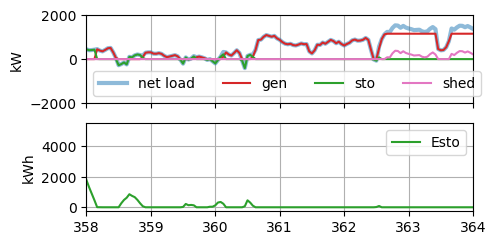

In [49]:
fig, (ax1, ax2) = plot_oper_traj2(td, mg_base.load,
    traj_alg_bb.Pgen,
    traj_alg_bb.Prenew_pot,
    traj_alg_bb.Pbatt,
    traj_alg_bb.power_shedding,
    traj_alg_bb.Ebatt,
)
ax1.set_ylim(-2000, 2000)
ax1.set_xlim(358, 364); # winter, end  of year, low wind -> shedding with Algebraic generator
fig.savefig("traj_alg_bb_358-364.png", dpi=250, bbox_inches="tight")

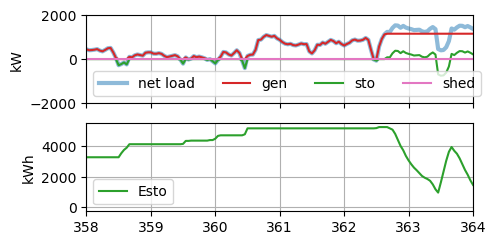

In [50]:
fig, (ax1, ax2) = plot_oper_traj2(td, mg_base.load,
    traj_alg.Pgen,
    traj_alg_bb.Prenew_pot,
    traj_alg.Psto,
    traj_alg.Pshed,
    traj_alg.Esto,
)
ax1.set_ylim(-2000, 2000)
ax1.set_xlim(358, 364); # winter, end  of year, low wind -> shedding with Algebraic generator
fig.savefig("traj_alg_358-364.png", dpi=250, bbox_inches="tight")

## Two-stage SP

*work in progress*: TODO update two-stage SP with above API changes of July 31, 2024

### Data for 2nd stage scenarios

3 equally probable fuel price changes

In [51]:
mg_base.generator.fuel_price

1.0

In [89]:
fuel_price_scenar = [0.5, 1.0, 1.5] # (decrease, constant, increase)
ns = length(fuel_price_scenar)
proba_scenar = [1., 1., 1.]/ns
println("number of scenarios: $ns")

number of scenarios: 3


In [90]:
#fuel_price_scenar = [fuel_price,] # (constant, for sanity check)
#ns = length(fuel_price_scenar)
#proba_scenar = [1.,]/ns
#println("number of scenarios: $ns")

### Helpers and model definition

In [91]:
"""Combine annualized cost of two project fragments:
- Cann1 during T1 years
- Cann2 during T2 years, starting after T1
"""
function Cann_total(Cann1, Cann2, T1, T2, discount_rate)
    CRFproj(T) = CRF(discount_rate, T)
    NPC1 = Cann1/CRFproj(T1)
    discount2 = 1/(1+discount_rate)^T1
    NPC2 = Cann2/CRFproj(T2) * discount2

    NPC = NPC1 + NPC2
    Cann = NPC*CRFproj(lifetime)
end

# test
m = Model()
@variable(m, Cann1)
@variable(m, Cann2)
println(Cann_total(Cann1, Cann2, 10, 15, 0.0001)) # 40% , 60%
println(Cann_total(Cann1, Cann2, 10, 15, 0.10))   # 68% , 32%

0.4003000099610032 Cann1 + 0.5996999900389431 Cann2
0.676935112477701 Cann1 + 0.3230648875222989 Cann2


In [92]:
"""Setup microgrid sizing optimization model using JuMP

# Parameters:
- `shed_max`: load shedding penalty threshold should be in  [0,1[
- `optimizer`: JuMP compatible optimization solver

# Optional keyword parameters
- `ndays=365`: data reduction
- `fixed_lifetimes`: true or false (default)
- `relax_gain`: 1.0 by default. Increase to try to compensation the underestimation
  of e.g. generator operating hours due to linearization.
- and some price params (keyword params)

Sizing maximum bounds are taken as the global variables
    power_rated_gen_max,
    energy_rated_sto_max,
    power_rated_pv_max,
    power_rated_wind_max

Returns:
- mg: base microgrid
- model_data Dict, with variables, named constraints and the JuMP model
- LCOE expression
"""
function setup_optim_mg_jump_2SP(shed_max, optimizer, Tmid;
        ndays=365,
        fixed_lifetimes=false,
        relax_gain = 1.0,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price1=fuel_price,
        fuel_price_scenar=fuel_price_scenar,
        proba_scenar=proba_scenar
    )
    ns = length(proba_scenar)
    println("number of 2nd stage scenarios: $ns")

    # base Microgrid with 1kW(h) ratings
    T1 = Tmid
    # TODO: decide where to change prices: in create_microgrid or in build model!!!
    mg1 = create_microgrid([1., 1., 1., 1.];
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price,
        lifetime=T1
    )
    T2 = lifetime-Tmid
    
    mg2 = [create_microgrid([1., 1., 1., 1.];
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price=fuel_price_scenar[s],
        lifetime=lifetime-Tmid
    ) for s=1:ns]

    # JuMP model setup
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    
    md1 = Dict{String,Any}()
    md1["model"] = model
    build_optim_mg_stage!(mg1, shed_max, md1;
        ndays, fixed_lifetimes, relax_gain,
        investment_price_sto, investment_price_gen,
        fuel_price=fuel_price1
    )
    
    md2 = [Dict{String,Any}() for s=1:ns]
    for s=1:ns
        md2[s]["model"] = model
        build_optim_mg_stage!(mg2[s], shed_max, md2[s];
            ndays, fixed_lifetimes, relax_gain,
            investment_price_sto, investment_price_gen,
            fuel_price=fuel_price_scenar[s]
        )
    end    

    discount_rate = mg1.project.discount_rate
    Cann_scenar = [
        Cann_total(md1["Cann"], md2[s]["Cann"], T1, T2, discount_rate)
        for s=1:ns]
    # Expected annualized cost
    Cann = Cann_scenar' * proba_scenar
    
    dt = mg1.project.timestep
    Eload_desired = sum(mg1.load)*dt*365/ndays
    LCOE = Cann/Eload_desired

    @objective(model, Min, Cann)

    return mg1, md1, md2, LCOE
end

setup_optim_mg_jump_2SP

In [93]:
"""Optimize sizing of microgrid optimization using JuMP

Parameters: see `setup_optim_mg_jump`. Extra optional parameter:
- `model_custom`: a function taking `model_data` as arg and which can modify the optimization model
"""
function optim_mg_jump_2SP(shed_max, optimizer, Tmid;
        model_custom=nothing,
        ndays=365,
        fixed_lifetimes=false,
        relax_gain=1.0,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price1=fuel_price,
        fuel_price_scenar=fuel_price_scenar,
        proba_scenar=proba_scenar
    )
    # Create model
    mg1_base, md1, md2, LCOE = setup_optim_mg_jump_2SP(shed_max, optimizer, Tmid;
        ndays=ndays,
        fixed_lifetimes=fixed_lifetimes,
        relax_gain=relax_gain,
        investment_price_sto=investment_price_sto,
        investment_price_gen=investment_price_gen,
        fuel_price1=fuel_price1,
    )
    model = md1["model"]
    
    if model_custom !== nothing
        model_custom(md1)
        model_custom.(md2)
    end

    # Stage coupling constraints:
    @constraint(model, [s=1:ns], md2[s]["power_rated_pv"] >= md1["power_rated_pv"]) # PV cannot decrease
    @constraint(model, [s=1:ns], md2[s]["power_rated_wind"] >= md1["power_rated_wind"]) # wind cannot decrease

    # Display model stats before solving
    show(model)
    # Optimize
    println("optmization started")
    @time JuMP.optimize!(model)

    # Extract results
    LCOE_opt = value(LCOE)
    x_varnames = ["power_rated_gen", "energy_rated_sto", "power_rated_pv", "power_rated_wind"]
    xopt1 = value.([
        md1["power_rated_gen"]
        md1["energy_rated_sto"]
        md1["power_rated_pv"]
        md1["power_rated_wind"]
    ])
    xopt2 = value.([
        md2[s][name] for name in x_varnames, s=1:ns
    ])
    return LCOE_opt, xopt1, xopt2, md1, md2
end

optim_mg_jump_2SP

In [94]:
optimizer = HiGHS.Optimizer
#optimizer = Clp.Optimizer
Tmid= 10 # y
lcoe_alg_2SP, xalg_S1, xalg_S2, md1, md2 = optim_mg_jump_2SP(shed_max, optimizer, Tmid;
    ndays=365,
    relax_gain=1.0,
    investment_price_sto=investment_price_sto*0.25,
    investment_price_gen=investment_price_gen,
    fuel_price1=fuel_price,
    fuel_price_scenar=fuel_price_scenar,
    proba_scenar=proba_scenar
)
lcoe_alg_2SP

number of 2nd stage scenarios: 3
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
Building stage problem with 365 days...
Usage-dependant lifetime hypothesis for generator (relax_gain=1.0)
A JuMP Model
Minimization problem with:
Variables: 315396
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 175212 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 35150 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 175204 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 35040 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 140192 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
Model mode: AUTOMA

0.17060043890892865

LCOE: `0.170 600 438 908 92865` \\$/kWh (two stage with fuel price scenario [0.5, 1.0, 1.5]\\$/l), with PV and wind *nondecrease* constraint. Solving time: 180s (×12 compared to single stage)

Sanity check: if 2nd stage scenario is constant (fuel price at 1.0 \\$/l), then we indeed get LCOE `0.171 593 718 600 32852` and two identical stage sizings, equal to the single stage base case. Solving time 45 s (×3 compared to single stage)

Optimal sizing at all stages:

In [95]:
round.([xalg_S1 xalg_S2]; digits=1) 

4×4 Matrix{Float64}:
 1190.0  1228.9  1151.3  1077.8
 4187.6  2752.8  5227.9  7164.0
 1791.9  1791.9  2055.0  2556.4
 1209.1  1209.1  1234.5  1351.6

Obtained sizing: $x^*=$

```
    S1 1.0  S2 0.5  S2 1.0  S2 1.5 $/l
Gen 1190.0  1228.9  1151.3  1077.8
Sto 4187.6  2752.8  5227.9  7164.0
PV  1791.9  1791.9  2055.0  2556.4
Win 1209.1  1209.1  1234.5  1351.6
```

For comparison: single stage base case:

LCOE: `0.171 593 718 600 3287` 

Sizing $x^*$:
```
 1151.3
 5227.9
 2055.0
 1234.5
```

Observations:
- Stage 1 of 2SP is
  - *matching S2 low price scenar* for the PV and wind ratings
  - uses slightly bigger gen (1190 vs 1151 kW)  and slightly smaller "anything else" (Sto, PV, wind) than the single stage base case
- Stage 2 mid price scenar *matches exactly* the single stage base case
- Stage 2 low price scenar downsizes the battery (4.2 to 2.8 MWh). Gen is slightly bigger
- Stage 2 high price scenar oversize the battery (4.2 to 7.2 MWh). PV and wind also, but just slighlty. Gen is slightly smaller.
- Wind ratings increases for S2 mid and high price scenar are so small that there are not realistic. A practical application would require rerunning the optim by requiring a constant wind sizing (or adding a nonconvex fixed price penalty to discourage small wind additions). 

*→ it seems to work!*